# CIFAR-10 images classification challenge

## Loading data and checking structure

Let's do some exploratory data analysis. First we'll load the data from the files downloaded from CIFAR website.

In [1]:
#importing libraries

#general libraries
import pickle
import collections
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#keras library
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.utils import np_utils

#skimage library
from skimage.transform import resize
from skimage.feature import hog

#sklearn library
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

#ipython magics
%config IPCompleter.greedy=True

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

def preprocess_inception (df, only_reshape=False): 
    #the function first reshapes the input data to proper image format. Later it resizes the imagest to fit InceptionV3 net.
    #The last layer is removed from the net and features are extracted.
    
    df_small_reshaped=[]
    time_start=time.time() #timer
    for i in range(len(df)): 
        df_small_reshaped.append(df[i].reshape(3,1024).T.reshape(32,32,3))
    df= np.asarray(df_small_reshaped)
    print("Image data reshaped")
    if only_reshape:
        print("selected only reshaping mode")
        return df
    
    #removing top layer, input shape set to default for inception model
    model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3)) 
    print("Model created")
    
    df_train_resized = np.array([resize(df[i], (139, 139, 3)) 
                        for i in range(0, len(df))]).astype('float32')
    print("image resized to suit inception model")
    features_inception = model.predict(df_train_resized, verbose=1)
    print("features predicted")
    features_inception = np.squeeze(features_inception)
    features_inception = features_inception.reshape((len(df), 3*3*2048))
    print("features reshaped to suit sklearn models")
    print("total time:  ", time.time()-time_start, " s")
    return features_inception
    

In [3]:
#Snippet taken from cifar-10 website unpacking the data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Checking labels of the images:

In [4]:
unpickle('data\\batches.meta')

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

Checking structure of one training batch:

In [5]:
batch1 = unpickle('data\data_batch_1')
print("Keys of one batch dictionary are: ", list(batch1.keys()))
print("Shape of dataset is ", batch1[b'data'].shape)

print("Checking the distribution of labels: ", dict(collections.Counter(batch1[b'labels'])))

Keys of one batch dictionary are:  [b'batch_label', b'labels', b'data', b'filenames']
Shape of dataset is  (10000, 3072)
Checking the distribution of labels:  {6: 1030, 9: 981, 4: 999, 1: 974, 2: 1032, 7: 1001, 8: 1025, 3: 1016, 5: 937, 0: 1005}


Everything is loaded properly. Let's now load the full training dataset:

In [6]:
x=batch1[b'data']
y=batch1[b'labels']

for i in range(2,6):
    temp_dict= unpickle('data\data_batch_'+str(i) )
    x=np.append(x, temp_dict[b'data'], axis=0)
    y=y+temp_dict[b'labels']

#### Randomly selecting images to modelling

Because I didn't have access to proper GPU, I used 1/10 of the dataset for training and 1/20 for validation.

In [7]:
#train and test sets
x_left, x_train, y_left, y_train = train_test_split(
    x, y, test_size=0.1, random_state=42)
x_left, x_test, y_left, y_test = train_test_split(
    x_left, y_left, test_size=0.05, random_state=42)

#remove auxiliary data
del x_left
del y_left
del x
del y
x_train.shape

(5000, 3072)

#### Wisualising the images

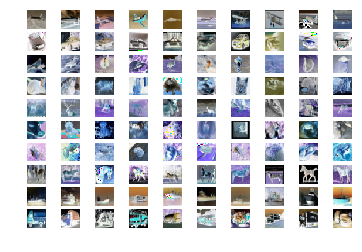

In [8]:
%matplotlib inline
examples_indexes=[]
for number in range(0,11):
    examples_indexes.append( [i for i, n in enumerate(y_train) if n==number][0:10])

examples_images=[]
for i in examples_indexes:
    examples_images=examples_images+i
    
    
for i in range(len(examples_images)):
    
    examples_images[i]= Image.fromarray((x_train[examples_images[i]].reshape(3,1024).T.reshape(32,32,3)*255).astype('uint8'), 'RGB')
    


for i in range(1,101):
    plt.subplot(10,10,i)
    plt.imshow(examples_images[i-1])
    plt.axis("off")

## Training a shallow classifier

To serve as a benchmark for next tests, I'm using HOG technique to extract features from the images and then I'm training SVM classifier on top of it.

In [9]:
#preprocessing image dataset to greyscale
features_hog_train= preprocess_inception(x_train, only_reshape=True)
features_hog_test= preprocess_inception(x_test, only_reshape=True)
features_hog_train=np.squeeze((0.21 * features_hog_train[:,:,:,:1]) + (0.72 * features_hog_train[:,:,:,1:2]) + (0.07 * features_hog_train[:,:,:,-1:]))
features_hog_test=np.squeeze((0.21 * features_hog_test[:,:,:,:1]) + (0.72 * features_hog_test[:,:,:,1:2]) + (0.07 * features_hog_test[:,:,:,-1:]))

Image data reshaped
selected only reshaping mode
Image data reshaped
selected only reshaping mode


In [10]:
def compute_hog(data):
    hog_features=[]
    for image in data:
        hog_features.append( hog(image, orientations=8))

    hog_features=np.asarray(hog_features)
    return hog_features

In [11]:
features_hog_train=compute_hog(features_hog_train)
features_hog_test=compute_hog(features_hog_test)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [12]:
#creating shallow classifier using hog features
hog_clf = LinearSVC(C=2)
hog_fitted = hog_clf.fit(features_hog_train, np.asarray(y_train))  


In [13]:
hog_predicted = hog_fitted.predict(features_hog_test)

In [14]:
print("Accuracy using this technique is ", round(accuracy_score(hog_predicted, y_test),4))

Accuracy using this technique is  0.4382


As we can see, accuracy using shallow classifier isn't very promising. Next step is to use state-of-the-art InceptionV3 model to obtain features.

## Classification task using transfer learning

As the shallow classifier didn't perform well, I'm going to try transfer learning approach. First step is to extract features using InceptionV3 model, but with removed last layer. Next I visualize obtained features. Then I check some out-of-the box SVM classifier and see how it performs. Lastly I use GridSeach cross validation to select best penalty for the model (C parameter).

#### Preprocessing dataset and extracting features

In [15]:
#creating training and test sets using features extraction
features_inception_train = np.load("backups/features_inception_train.npy")
features_inception_test = np.load("backups/features_inception_test.npy")
#features_inception_test = preprocess_inception(x_test)
#features_inception_train = preprocess_inception(x_train)
#np.save("backups/features_inception_train.npy", features_inception_train)
#np.save("backups/features_inception_test.npy", features_inception_test)

#### Using t-sne technique to visualise CNN codes

T-sne technique is suitable for high-dimensional, non-linear data. In previous tests I also used PCA technique, but the results were less promising.

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features_inception_train)

print ('T-sne done. Total time: ', time.time()-time_start, " s")

In [ ]:
#np.save("backups/t-sne-1.npy", tsne_results)
tsne_results = np.load("backups/t-sne-1.npy")

In [ ]:
import seaborn as sns
import pandas as pd
tsne_df = pd.DataFrame({'x1':tsne_results[:,0], 'x2':tsne_results[:,1], 'label':y_train})
sns.set(rc={'figure.dpi':100})
sns.lmplot(x='x1', y='x2',
                hue='label',
                data=tsne_df,
           fit_reg=False,
           scatter_kws={"s": 5}
                )
plt.title("Features projection using t-SNE technique")

#### Creating out-of the-box svm classifier

As the first try I'm using svm classifier with default parameters.

In [11]:
to_norm = features_inception_train.max() #checking max value for normalisation before passing data to the model

In [13]:
time_start = time.time()

clf_linear = LinearSVC() #by default C=1
fitted_inception = clf_linear.fit(features_inception_train/to_norm, np.asarray(y_train))  
print()
print("Model fitted. Total fitting time: ", time.time()-time_start, "s")


Model fitted. Total fitting time:  76.72095060348511 s


Checking basic stats regarding the model:

In [22]:
inception_predicted_train = fitted_inception.predict(features_inception_train)
inception_predicted_test = fitted_inception.predict(features_inception_test)
print('Accuracy on the training set:', round(accuracy_score(inception_predicted_train, np.asarray(y_train)),4))
print('Accuracy on the test set:', round(accuracy_score(inception_predicted_test, np.asarray(y_test)),4))
#print(confusion_matrix(inception_predicted_train, np.asarray(y_train)))

Accuracy on the training set: 0.9998
Accuracy on the test set: 0.7271


Such high accuracy on the training set and relatively low on the test set indicate the overfitting problem. In this case the best solution would be to gather more data. As it's not feasible in this case (due to high memory usage), changing hyperparameter C would be the best idea. The intuition says that lowering it would help so I'm going to use cross validation to select the best value. 


#### Using random CV to select best parameters

In [23]:
hyperparameters={'C':[0.001, 0.01, 0.1, 1]}
clf_cv = GridSearchCV(LinearSVC(verbose=1, random_state=1), hyperparameters, cv=2, verbose=1, n_jobs=-1,return_train_score=True)

model_gridCV = clf_cv.fit(features_inception_train/to_norm, np.asarray(y_train))
model_gridCV.cv_results_

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.8min finished


[LibLinear]

{'mean_fit_time': array([52.06736279, 82.23044038, 80.06489646, 60.66847718]),
 'std_fit_time': array([10.11146212,  6.90935397,  2.91829813,  0.43632758]),
 'mean_score_time': array([15.71349597, 20.41391945,  6.65339768,  1.24355924]),
 'std_score_time': array([1.00615993e+01, 1.87446117e-01, 4.13503563e+00, 6.04498386e-03]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}],
 'split0_test_score': array([0.64522573, 0.69676388, 0.72273272, 0.70914902]),
 'split1_test_score': array([0.66359632, 0.71565879, 0.73648378, 0.71285543]),
 'mean_test_score': array([0.6544, 0.7062, 0.7296, 0.711 ]),
 'std_test_score': array([0.00918529, 0.00944745, 0.00687552, 0.0018532 ]),
 'rank_test_score': array([4, 3, 1, 2]),
 'split0_train_score': array([0.71846215, 0.86663997, 0.98438126, 1.        ]),
 'split1_train_score': array([0.716340

The best C value from the selected ones is 0.1. To further improve the accuracy we could search hyperparameter space just around this value. But still, the accuracy obtained isn't satisfactiory. As I'm still tackling the overfitting problem, I'm gonna use PCA to project data into lower dimensions and check if it gets me somewhere.

#### Using PCA to prevent overfitting

To check the optimal cut-off point I'm gonna plot no. of features vs. the variance explained

pca finished


Text(0,0.5,'cumulative explained variance')

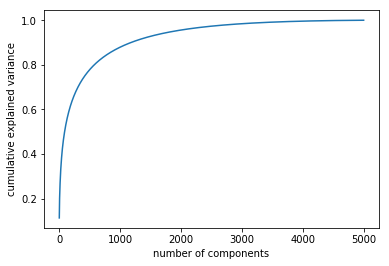

In [12]:
pca = PCA().fit(features_inception_train/to_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


I will be using enough components to capture roughly 0.9 of variance.

In [50]:
pca_reduced= PCA(n_components= 2000,svd_solver='randomized', random_state=1).fit(features_inception_train/to_norm)
pca_reduced_train= pca_reduced.transform(features_inception_train/to_norm)
pca_reduced_test= pca_reduced.transform(features_inception_test/to_norm)

For readability the cross validation procedure isn't included in this notebook, but best value obtained for C was again 0.1.

In [51]:
to_norm_pca = pca_reduced_train.max()

In [52]:
#using svm to classify test data
clf_pca = LinearSVC(verbose=1, C=0.1)
print("model created")
fitted_inception_pca = clf_pca.fit(pca_reduced_train/to_norm_pca, np.asarray(y_train))  

predicted_svm_pca = fitted_inception_pca.predict(pca_reduced_test/to_norm_pca)

model created
[LibLinear]

In [61]:
print("Accuracy: ",round(accuracy_score(predicted_svm_pca, y_test),4))
#accuracy is lower than using data without pca transformation

Accuracy:  0.7271


Using PCA didn't show much improvement. Last attempt in my analysis to improve accuracy is to use neural net trained on top of Inception model and see how well it performs.

## Creating classifier neural net on top of inception architecture

Now I'm going to try using some basic neural net to classify the images. I'm using features precomputed by the Inception model. 

In [29]:


# one-hot encode the labels
y_train_onehot = np_utils.to_categorical(y_train, 10)
y_test_onehot = np_utils.to_categorical(y_test, 10)

In [58]:

#creating some basic model
model_custom= Sequential()
model_custom.add(Dense(units=400, input_dim=18432, activation='relu'))
model_custom.add(Dropout(0.5))
model_custom.add(Dense(units=10, activation='softmax'))

model_custom.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [62]:
model_custom.fit(features_inception_train, y_train_onehot, epochs=25, batch_size=50, verbose=2, validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
 - 13s - loss: 0.0570 - acc: 0.9943 - val_loss: 0.9137 - val_acc: 0.7340
Epoch 2/5
 - 13s - loss: 0.0579 - acc: 0.9915 - val_loss: 0.9364 - val_acc: 0.7370
Epoch 3/5
 - 14s - loss: 0.0494 - acc: 0.9948 - val_loss: 0.9546 - val_acc: 0.7320
Epoch 4/5
 - 21s - loss: 0.0477 - acc: 0.9938 - val_loss: 0.9483 - val_acc: 0.7310
Epoch 5/5
 - 18s - loss: 0.0452 - acc: 0.9945 - val_loss: 0.9601 - val_acc: 0.7300


In [63]:
predicted_nn=model_custom.evaluate(features_inception_test,y_test_onehot)
print("Accuracy on the test set: ", round(predicted_nn[1],4))

2250/2250 [==============================] - 3s 1ms/step


Accuracy obtained on the test set is a little bit higher than using SVM classifier.